In [6]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

iwa = 2.8
owa = 9.7

In [2]:
import proper
import roman_phasec_proper
proper.__version__, roman_phasec_proper.__version__

('3.2.5', '1.2.8')

# Load PSFs

In [7]:
psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20220920.fits'
psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20221006.fits'

psfs = fits.getdata(psfs_fpath)
print(psfs.shape, len(psfs))
fits.getheader(psfs_fpath)

(3331, 64, 64) 3331


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   64                                                  
NAXIS2  =                   64                                                  
NAXIS3  =                 3331                                                  
PXSCLAMD=   0.4347826086956522 / pixel scale in lam0/D per pixel                
PXSCLMAS=    21.82142167566928 / pixel scale in mas per pixel                   
PIXELSCL=              1.3E-05 / pixel scale in meters per pixel                
CWAVELEN=             5.75E-07 / central wavelength in meters                   
BANDPASS=                  0.1 / bandpass as fraction of CWAVELEN               
POLAXIS =                   10 / polaxis: defined by roman_phasec_proper        

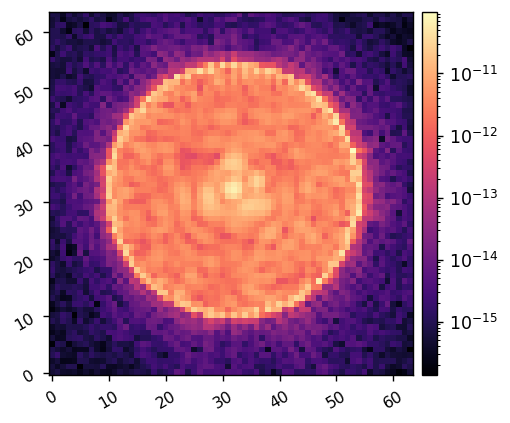

In [4]:
misc.myimshow(psfs[0], lognorm=True)

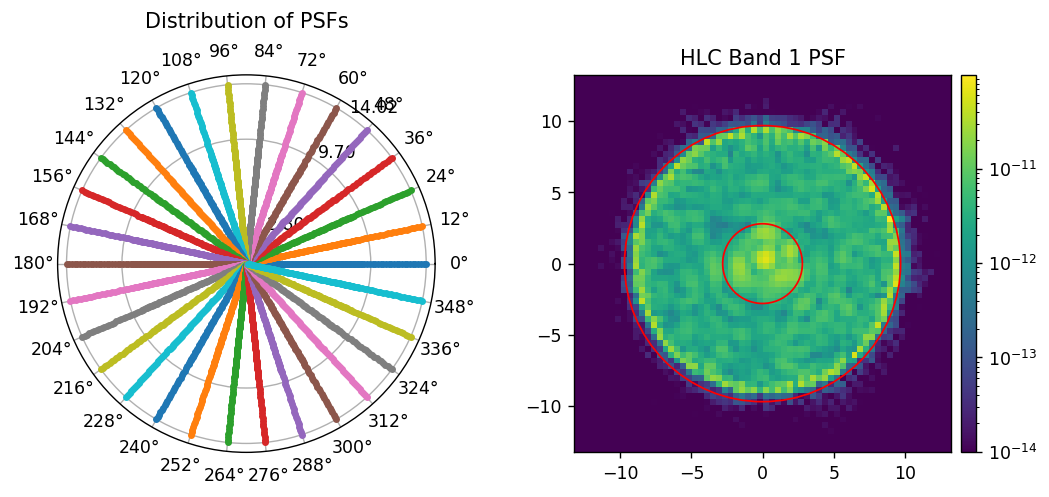

In [8]:
r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20220920.fits'
thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20220920.fits'
r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20221006.fits'
thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20221006.fits'

r_offsets = fits.getdata(r_offsets_fpath)
thetas = fits.getdata(thetas_fpath)*u.degree

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(10,4))

ax1 = plt.subplot(121, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.')
ax1.set_rticks([iwa, owa, max(r_offsets)])  # Less radial ticks
ax1.set_thetagrids(thetas.value)
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.grid(True)
ax1.set_title('Distribution of PSFs', va='bottom')

ax2 = plt.subplot(122)
ext = [-psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2,
       -psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2]
im = ax2.imshow(psfs[0], norm=LogNorm(vmin=psfs[0].max()/1e4), cmap='viridis', extent=ext)
ax2.add_patch(Circle((0, 0), iwa, color='r', fill=False))
ax2.add_patch(Circle((0, 0), owa, color='r', fill=False))
ax2.set_title('HLC Band 1 PSF')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.075)
fig.colorbar(im, cax=cax)

In [16]:
r_offsets, thetas

(array([ 0.        ,  0.10460403,  0.20920806,  0.3138121 ,  0.41841613,
         0.52302016,  0.62762419,  0.73222823,  0.83683226,  0.94143629,
         1.04604032,  1.15064435,  1.25524839,  1.35985242,  1.46445645,
         1.56906048,  1.67366452,  1.77826855,  1.88287258,  1.98747661,
         2.09208064,  2.19668468,  2.30128871,  2.40589274,  2.51049677,
         2.61510081,  2.71970484,  2.82430887,  2.9289129 ,  3.03351693,
         3.13812097,  3.242725  ,  3.34732903,  3.45193306,  3.55653709,
         3.66114113,  3.76574516,  3.87034919,  3.97495322,  4.        ,
         4.10460403,  4.20920806,  4.3138121 ,  4.41841613,  4.52302016,
         4.62762419,  4.73222823,  4.83683226,  4.94143629,  5.04604032,
         5.15064435,  5.25524839,  5.35985242,  5.46445645,  5.56906048,
         5.67366452,  5.77826855,  5.88287258,  5.98747661,  6.09208064,
         6.19668468,  6.30128871,  6.40589274,  6.51049677,  6.61510081,
         6.71970484,  6.82430887,  6.9289129 ,  7.0

# Setup/Test the interpolating function

In [17]:
r_offsets_mas = r_offsets * mas_per_lamD

# def find_closest_psf(xoff, yoff, verbose=True):
#     r = np.sqrt(xoff**2+yoff**2)
#     theta = np.arctan2(yoff,xoff).to(u.deg)
#     if theta<0: theta += 360*u.deg
        
#     kr = np.argmin(np.abs(r_offsets_mas-r))
#     if kr>(len(r_offsets)-1):
#         kr = len(r_offsets)-1
#     kth = np.argmin(np.abs(thetas-theta))
#     theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
#     if kr==0: 
#         kpsf=0
#     else: 
#         kpsf = 1 + kth + (len(thetas))*(kr-1)
    
#     if verbose: 
#         print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
#         print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
#         print('PSF index = {:d}'.format(kpsf))
    
#     closest_psf = psfs[kpsf]
#     interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=5)
    
#     return interpped_psf

def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=0)
    
    return interpped_psf

In [44]:
20.8*(5*npsf//7 - npsf//2)

270.40000000000003

Desired r=270.00 mas, radial index=52, closest available r=269.01 mas
Desired th=100.00 deg, theta index=8, closest available th=96.00 deg, difference=4.00 deg
PSF index = 1539


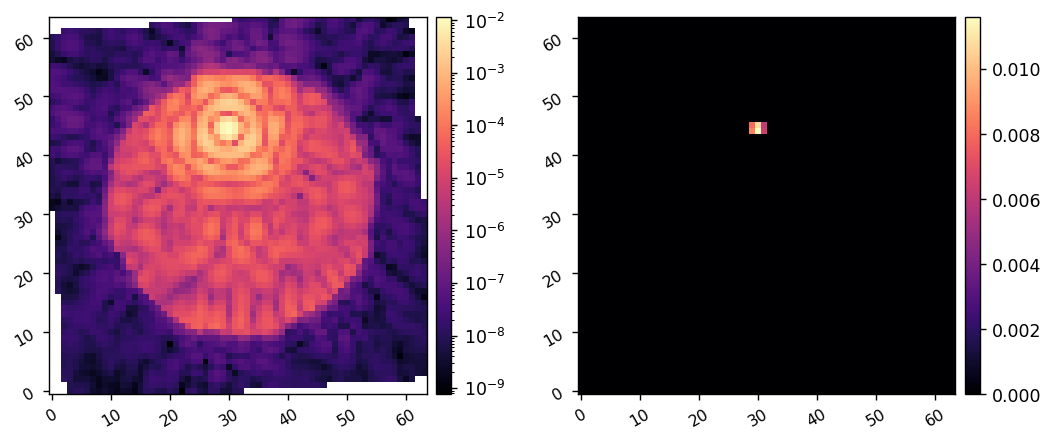

0.05164729745201808

In [19]:
r = 270*u.mas
th = 100*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

mask = (psf>psf.max()/2)

misc.myimshow2(psf, mask*psf, lognorm1=True)
np.sum(mask*psf)

# Create the grid for which the interpolated PSFs will be calculated

In [20]:
ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-655.2, -634.4, -613.6, ...,  613.6,  634.4,  655.2] mas>

Desired r=926.59 mas, radial index=111, closest available r=703.70 mas
Desired th=225.00 deg, theta index=19, closest available th=228.00 deg, difference=-3.00 deg
PSF index = 3320


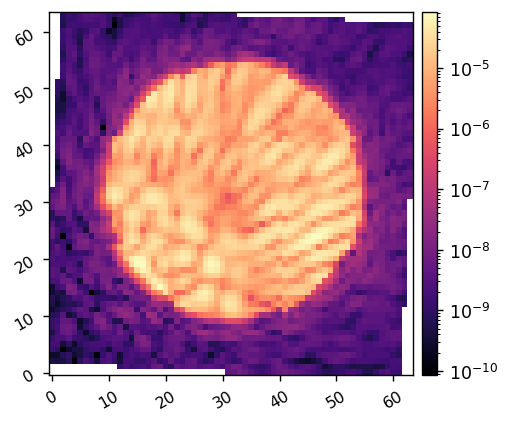

In [21]:
xoff = x[0]
yoff = y[0]
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

In [23]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

4095 3.5667550563812256


In [24]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20221006.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()

# load and see if the matrix is correct

In [26]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20220920.hdf5'
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20221006.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

In [10]:
ipsf_matrix.shape

(4096, 4096)

In [32]:
x.shape

(4096,)

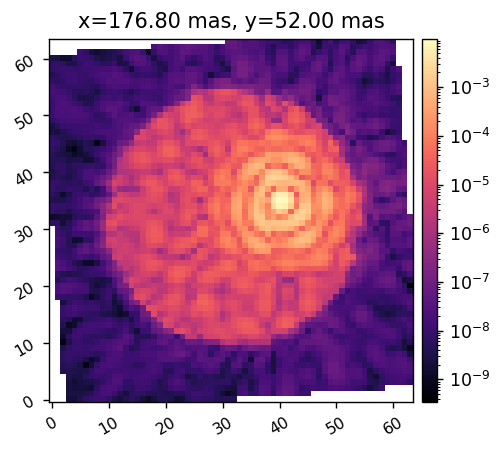

In [34]:
start = ipsf_matrix.shape[0]//2
for i in range(start, ipsf_matrix.shape[0]):
    try:
        misc.myimshow(ipsf_matrix[:,i].reshape(npsf,npsf), 'x={:.2f}, y={:.2f}'.format(x[i], y[i]), lognorm=True)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break